In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
%matplotlib inline

# File paths


In [42]:
training_file_path = "/content/solar_training.csv"
test_file_path = "/content/solar_test.csv"

# Reading the data


In [43]:
training_data = pd.read_csv(training_file_path)
test_data = pd.read_csv(test_file_path)

# Displaying the first few rows of the training and test data


In [44]:
training_data_head = training_data.head()
test_data_head = test_data.head()

In [45]:
(training_data_head, test_data_head)


(   ZONEID       TIMESTAMP     VAR78     VAR79      VAR134     VAR157  \
 0       1  20120401 01:00  0.001967  0.003609  94843.6250  60.221909   
 1       1  20120401 02:00  0.005524  0.033575  94757.9375  54.678604   
 2       1  20120401 03:00  0.030113  0.132009  94732.8125  61.294891   
 3       1  20120401 04:00  0.057167  0.110645  94704.0625  67.775284   
 4       1  20120401 05:00  0.051027  0.189560  94675.0000  70.172989   
 
      VAR164    VAR165    VAR166      VAR167      VAR169     VAR175  \
 0  0.244601  1.039334 -2.503039  294.448486   2577830.0  1202532.0   
 1  0.457138  2.482865 -2.993330  295.651367   5356093.0  2446757.0   
 2  0.771429  3.339867 -1.982535  294.454590   7921788.0  3681336.0   
 3  0.965866  3.106102 -1.446051  293.261475   9860520.0  4921504.0   
 4  0.944669  2.601146 -1.904493  292.732910  11143097.0  6254380.0   
 
        VAR178    VAR228     POWER  
 0   2861797.0  0.000000  0.754103  
 1   5949378.0  0.000000  0.555000  
 2   8939176.0  0.001

# Checking for missing values in both datasets


In [46]:
missing_values_training = training_data.isnull().sum()
missing_values_test = test_data.isnull().sum()

# Converting the 'TIMESTAMP' column to datetime format in both datasets


In [47]:
training_data['TIMESTAMP'] = pd.to_datetime(training_data['TIMESTAMP'], format='%Y%m%d %H:%M')
test_data['TIMESTAMP'] = pd.to_datetime(test_data['TIMESTAMP'], format='%Y%m%d %H:%M')

# Displaying the missing values information and the head of the datasets to confirm the TIMESTAMP conversion

In [48]:
missing_values_info = {
    "Training Data Missing Values": missing_values_training,
    "Test Data Missing Values": missing_values_test
}

In [49]:
(training_data.head(), test_data.head(), missing_values_info)

(   ZONEID           TIMESTAMP     VAR78     VAR79      VAR134     VAR157  \
 0       1 2012-04-01 01:00:00  0.001967  0.003609  94843.6250  60.221909   
 1       1 2012-04-01 02:00:00  0.005524  0.033575  94757.9375  54.678604   
 2       1 2012-04-01 03:00:00  0.030113  0.132009  94732.8125  61.294891   
 3       1 2012-04-01 04:00:00  0.057167  0.110645  94704.0625  67.775284   
 4       1 2012-04-01 05:00:00  0.051027  0.189560  94675.0000  70.172989   
 
      VAR164    VAR165    VAR166      VAR167      VAR169     VAR175  \
 0  0.244601  1.039334 -2.503039  294.448486   2577830.0  1202532.0   
 1  0.457138  2.482865 -2.993330  295.651367   5356093.0  2446757.0   
 2  0.771429  3.339867 -1.982535  294.454590   7921788.0  3681336.0   
 3  0.965866  3.106102 -1.446051  293.261475   9860520.0  4921504.0   
 4  0.944669  2.601146 -1.904493  292.732910  11143097.0  6254380.0   
 
        VAR178    VAR228     POWER  
 0   2861797.0  0.000000  0.754103  
 1   5949378.0  0.000000  0.555000

# Removing rows with missing values from the test dataset

In [50]:
test_data_cleaned = test_data.dropna()

# Checking if all missing values are removed

In [51]:
remaining_missing_values_test = test_data_cleaned.isnull().sum()

In [52]:
test_data_cleaned.head(), remaining_missing_values_test

(   ZONEID           TIMESTAMP     VAR78  VAR79      VAR134     VAR157  \
 0     1.0 2013-07-01 01:00:00  0.001335    0.0  95342.6875  74.118164   
 1     1.0 2013-07-01 02:00:00  0.000179    0.0  95259.6875  67.015564   
 2     1.0 2013-07-01 03:00:00  0.000267    0.0  95166.3125  59.357101   
 3     1.0 2013-07-01 04:00:00  0.000572    0.0  95111.5000  54.863464   
 4     1.0 2013-07-01 05:00:00  0.000755    0.0  95100.5000  55.692444   
 
      VAR164    VAR165    VAR166      VAR167     VAR169       VAR175  \
 0  0.048920  1.131939 -0.579174  282.172363  1557786.0   955170.625   
 1  0.005646  1.716605 -0.476846  284.574219  3380267.0  1906639.000   
 2  0.000000  2.750459 -0.378750  286.135742  5244430.0  2872777.000   
 3  0.000000  3.973446  0.103195  286.377685  6910629.0  3845137.000   
 4  0.000977  4.154067  0.386442  285.615723  8172020.0  4816626.000   
 
       VAR178  VAR228     POWER  
 0  1733948.0     0.0  0.123846  
 1  3728032.0     0.0  0.194103  
 2  5764803.0     

# Calculating basic statistics for the training and test datasets

In [53]:
training_stats = training_data.describe()
test_stats = test_data_cleaned.describe()

# Additional statistics: Variance and Mean Absolute Deviation (MAD)

In [54]:
training_variance = training_data.var()
training_mad = training_data.mad()
test_variance = test_data_cleaned.var()
test_mad = test_data_cleaned.mad()

<ipython-input-54-aad529a5f7ef>:1: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  training_variance = training_data.var()
<ipython-input-54-aad529a5f7ef>:2: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  training_mad = training_data.mad()
<ipython-input-54-aad529a5f7ef>:3: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_variance = test_data_cleaned.var()
<ipython-input-54-aad529a5f7ef>:4: FutureWarning: The 'mad' metho

# Compiling all statistics into a dictionary for a clearer presentation

In [55]:
statistics_info = {
    "Training Data Statistics": training_stats,
    "Test Data Statistics": test_stats,
    "Training Data Variance": training_variance,
    "Training Data MAD": training_mad,
    "Test Data Variance": test_variance,
    "Test Data MAD": test_mad
}

In [56]:
statistics_info

{'Training Data Statistics':              ZONEID         VAR78         VAR79        VAR134        VAR157  \
 count  32832.000000  32832.000000  32832.000000  32832.000000  32832.000000   
 mean       2.000000      0.039729      0.015692  93859.193390     68.544895   
 std        0.816509      0.113359      0.048724   1094.945197     19.713814   
 min        1.000000      0.000000      0.000000  90359.000000      8.525364   
 25%        1.000000      0.000000      0.000000  92946.750000     53.766098   
 50%        2.000000      0.002703      0.000100  94062.375000     71.495399   
 75%        3.000000      0.033705      0.006114  94701.890625     85.344917   
 max        3.000000      2.068974      0.606646  96308.062500    101.790909   
 
              VAR164        VAR165        VAR166        VAR167        VAR169  \
 count  32832.000000  32832.000000  32832.000000  32832.000000  3.283200e+04   
 mean       0.422735      0.684254     -0.104849    284.681270  1.186076e+07   
 std      

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a figure for multiple subplots

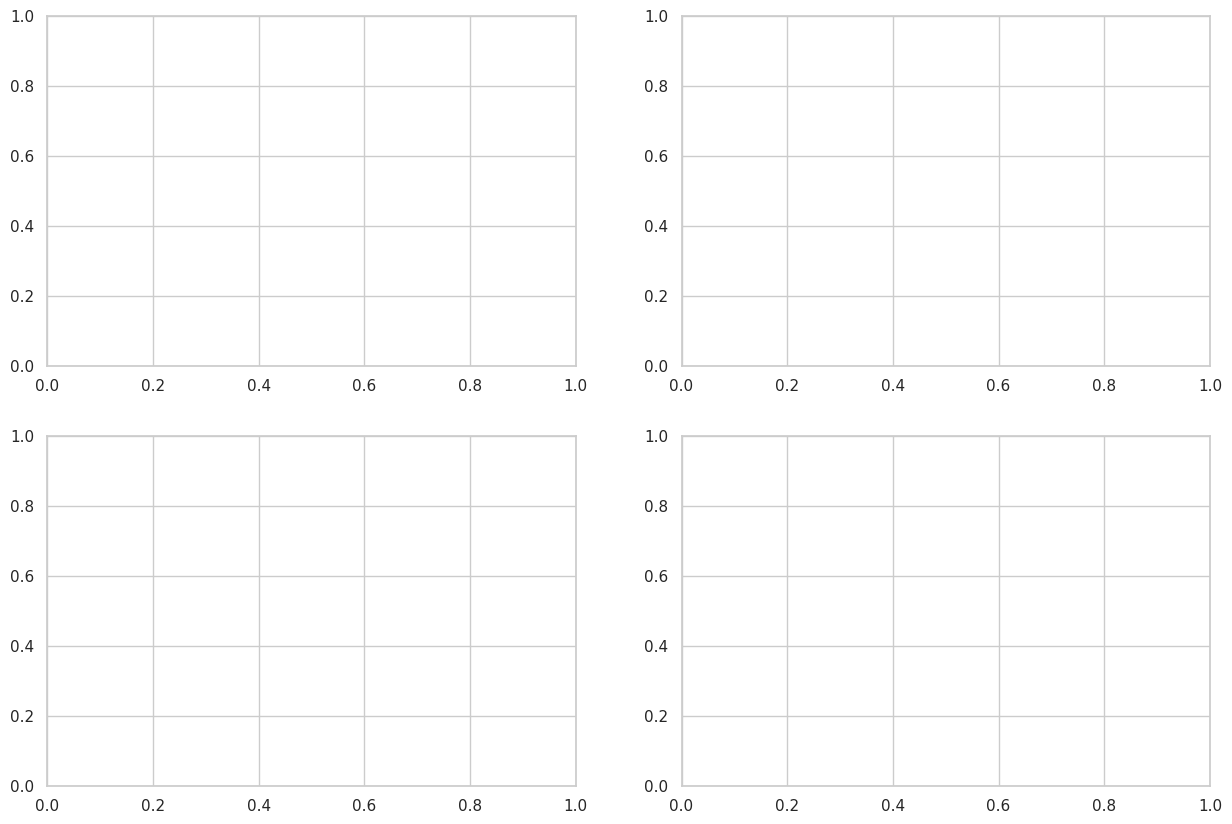

In [58]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Time Series Plot for Power Generation

In [59]:
training_data.groupby('TIMESTAMP')['POWER'].mean().plot(ax=axes[0, 0], color='blue', title='Time Series of Power Generation')
plt.show()

# Histogram for Power Generation

In [60]:
training_data['POWER'].plot(kind='hist', ax=axes[0, 1], bins=50, color='green', title='Histogram of Power Generation')
plt.show()

# Box Plot for Power Generation

In [61]:
sns.boxplot(x='ZONEID', y='POWER', data=training_data, ax=axes[1, 0], palette='Set2').set_title('Box Plot of Power Generation by Zone')

Text(0.5, 1.0, 'Box Plot of Power Generation by Zone')

# Correlation Heatmap

In [62]:
corr = training_data.drop(['ZONEID', 'TIMESTAMP'], axis=1).corr()
sns.heatmap(corr, ax=axes[1, 1], cmap='coolwarm', annot=False).set_title('Correlation Heatmap of Variables')

Text(0.5, 1.0, 'Correlation Heatmap of Variables')

# Adjusting layout

In [63]:
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

# Displaying the plots

In [103]:
plt.show()

# Adding new features for power values from 24 to 48 hours ago

In [65]:
for i in range(24, 49):
    training_data[f'POWER_{i}_hours_ago'] = training_data.groupby('ZONEID')['POWER'].shift(i)

 # Restructuring the dataset: The target variable is the power

---

generation 24 hours ahead

1.   List item
2.   List item



In [66]:
training_data['POWER_24_hours_ahead'] = training_data.groupby('ZONEID')['POWER'].shift(-24)

# Dropping rows with NaN values which are a result of the shifting operation

In [67]:
training_data_restructured = training_data.dropna()

# Displaying the first few rows of the restructured dataset to verify the new features

In [68]:
training_data_restructured.head()

,ZONEID,TIMESTAMP,VAR78,VAR79,VAR134,VAR157,VAR164,VAR165,VAR166,VAR167,...,POWER_40_hours_ago,POWER_41_hours_ago,POWER_42_hours_ago,POWER_43_hours_ago,POWER_44_hours_ago,POWER_45_hours_ago,POWER_46_hours_ago,POWER_47_hours_ago,POWER_48_hours_ago,POWER_24_hours_ahead
48,1,2012-04-03 01:00:00,0.090919,0.004616,94711.4375,63.741364,0.410126,0.304482,-0.324355,292.126465,...,0.000128,0.030064,0.088718,0.057244,0.111987,0.145449,0.438397,0.555000,0.754103,0.754103
49,1,2012-04-03 02:00:00,0.018543,0.000551,94638.3125,61.387207,0.029388,0.283238,-0.777376,293.629639,...,0.000000,0.000128,0.030064,0.088718,0.057244,0.111987,0.145449,0.438397,0.555000,0.745897
50,1,2012-04-03 03:00:00,0.003380,0.000016,94553.0000,56.486938,0.020172,0.474200,-1.141390,295.256103,...,0.000000,0.000000,0.000128,0.030064,0.088718,0.057244,0.111987,0.145449,0.438397,0.682756
51,1,2012-04-03 04:00:00,0.009621,0.000976,94501.0000,53.474503,0.630585,0.832374,-1.779152,296.464356,...,0.000000,0.000000,0.000000,0.000128,0.030064,0.088718,0.057244,0.111987,0.145449,0.521026
52,1,2012-04-03 05:00:00,0.019655,0.000321,94455.2500,52.380081,0.120308,1.060286,-2.266140,296.883057,...,0.000000,0.000000,0.000000,0.000000,0.000128,0.030064,0.088718,0.057244,0.111987,0.338462


# Creating a correlation matrix including the new features and the future power generation

In [69]:
correlation_matrix = training_data_restructured.iloc[:, -26:].corr()

# Plotting the correlation heatmap

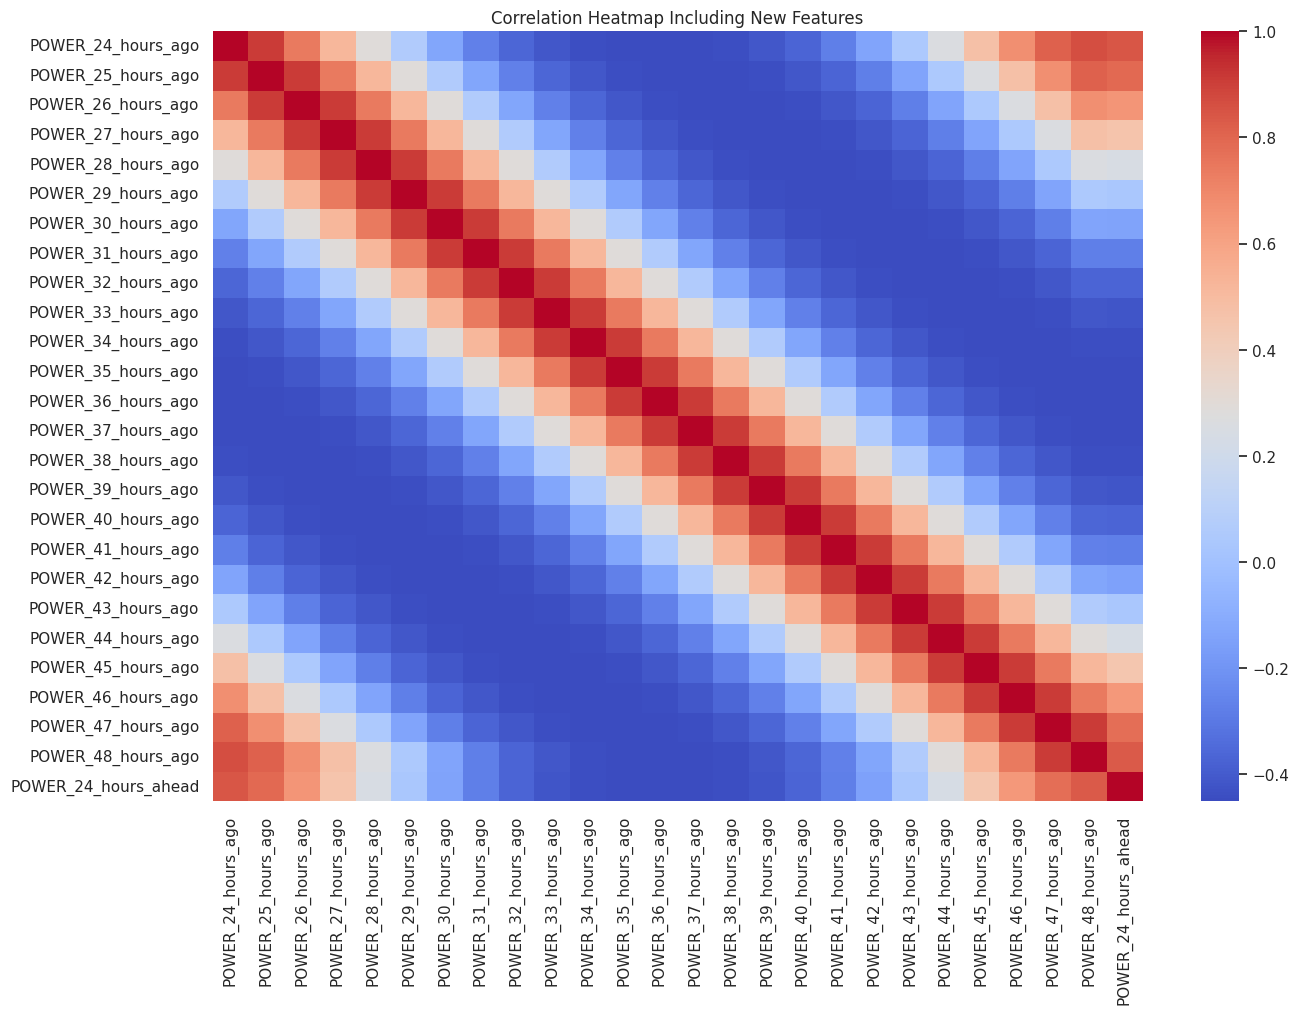

In [70]:
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap Including New Features')
plt.show()

# Preparing the features (X) and target (y) for MI calculation

In [71]:
X = training_data_restructured.iloc[:, -26:-1]  # All newly added features
y = training_data_restructured['POWER_24_hours_ahead']  # Future power generation

# Calculating Mutual Information

In [72]:
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)

# Sorting the scores for better visualization

In [73]:
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

POWER_24_hours_ago    1.130293
POWER_48_hours_ago    1.081980
POWER_25_hours_ago    0.699318
POWER_47_hours_ago    0.686186
POWER_36_hours_ago    0.559282
POWER_37_hours_ago    0.498739
POWER_35_hours_ago    0.494452
POWER_46_hours_ago    0.444791
POWER_26_hours_ago    0.443062
POWER_34_hours_ago    0.377813
POWER_38_hours_ago    0.374151
POWER_45_hours_ago    0.292831
POWER_27_hours_ago    0.288842
POWER_33_hours_ago    0.257146
POWER_39_hours_ago    0.251967
POWER_28_hours_ago    0.181334
POWER_44_hours_ago    0.179570
POWER_40_hours_ago    0.173350
POWER_32_hours_ago    0.169389
POWER_43_hours_ago    0.118053
POWER_29_hours_ago    0.117402
POWER_41_hours_ago    0.114342
POWER_31_hours_ago    0.105936
POWER_42_hours_ago    0.092726
POWER_30_hours_ago    0.089488
Name: MI Scores, dtype: float64

# Preparing data for each solar power plant (ZONEID)

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
zone_datasets = {}
for zone in training_data_restructured['ZONEID'].unique():
    zone_data = training_data_restructured[training_data_restructured['ZONEID'] == zone]

    # Dropping non-numeric and non-relevant columns
    zone_data = zone_data.drop(['ZONEID', 'TIMESTAMP'], axis=1)

    # Splitting data into features (X) and target (y)
    X = zone_data.drop('POWER_24_hours_ahead', axis=1)
    y = zone_data['POWER_24_hours_ahead']

    # Splitting each dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Storing the split data in a dictionary for easy access
    zone_datasets[zone] = (X_train, X_val, y_train, y_val)


# Verifying the data preparation

In [76]:
zone_datasets.keys(), zone_datasets[1][0].shape, zone_datasets[1][1].shape # Example shape for Zone 1's train and validation set

(dict_keys([1, 2, 3]), (8697, 38), (2175, 38))

# ******* Zone 1: All Models *******


# Training the data for Zone 1

In [77]:
X_train, X_val, y_train, y_val = zone_datasets[1]  # Data for Zone 1

# 1. Linear Regression

In [78]:
from sklearn.linear_model import LinearRegression

# Initialize the model
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train, y_train)

# Make predictions
predictions_lr = linear_model.predict(X_val)

# Evaluate the model
mae_lr = mean_absolute_error(y_val, predictions_lr)
rmse_lr = np.sqrt(mean_squared_error(y_val, predictions_lr))
(mae_lr, rmse_lr)

(0.06555901947840792, 0.11622359461770475)

# 2. Random Forest Regressor

In [79]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
predictions_rf = rf_model.predict(X_val)

# Evaluate the model
mae_rf = mean_absolute_error(y_val, predictions_rf)
rmse_rf = np.sqrt(mean_squared_error(y_val, predictions_rf))
(mae_rf, rmse_rf)

(0.053174812263485055, 0.10762606411912702)

# 3. Gradient Boosting Machine (GBM)

In [80]:

# Initialize the model
gbm_model = LGBMRegressor()

# Train the model
gbm_model.fit(X_train, y_train)

# Make predictions
predictions_gbm = gbm_model.predict(X_val)

# Evaluate the model
mae_gbm = mean_absolute_error(y_val, predictions_gbm)
rmse_gbm = np.sqrt(mean_squared_error(y_val, predictions_gbm))
(mae_gbm, rmse_gbm)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9689
[LightGBM] [Info] Number of data points in the train set: 8697, number of used features: 38
[LightGBM] [Info] Start training from score 0.167897


(0.04997813424758209, 0.10241261144172739)

# 4. Long Short-Term Memory (LSTM)

In [83]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Assuming X_train and y_train are already defined and properly formatted

# Reshape data for LSTM (example)
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_reshaped = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Initialize the model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with fewer epochs
lstm_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32)  # Reduced epochs to 10

# Make predictions
predictions_lstm = lstm_model.predict(X_val_reshaped)

# Evaluate the model
mae_lstm = mean_absolute_error(y_val, predictions_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_val, predictions_lstm))


Epoch 1/10
272/272 [==============================] - 10s 7ms/step - loss: 0.0523
Epoch 2/10
272/272 [==============================] - 2s 6ms/step - loss: 0.0494
Epoch 3/10
272/272 [==============================] - 1s 5ms/step - loss: 0.0488
Epoch 4/10
272/272 [==============================] - 1s 5ms/step - loss: 0.0488
Epoch 5/10
272/272 [==============================] - 1s 5ms/step - loss: 0.0486
Epoch 6/10
272/272 [==============================] - 2s 8ms/step - loss: 0.0486
Epoch 7/10
272/272 [==============================] - 2s 9ms/step - loss: 0.0484
Epoch 8/10
272/272 [==============================] - 2s 9ms/step - loss: 0.0485
Epoch 9/10
272/272 [==============================] - 3s 11ms/step - loss: 0.0484
Epoch 10/10
68/68 [==============================] - 1s 2ms/step


# 5. Support Vector Regression (SVR)

In [84]:
from sklearn.svm import SVR

# Initialize the model
svr_model = SVR()

# Train the model
svr_model.fit(X_train, y_train)

# Make predictions
predictions_svr = svr_model.predict(X_val)

# Evaluate the model
mae_svr = mean_absolute_error(y_val, predictions_svr)
rmse_svr = np.sqrt(mean_squared_error(y_val, predictions_svr))

# 6. Lasso Regression


In [85]:
from sklearn.linear_model import Lasso

# Initialize the model
lasso_model = Lasso(alpha=0.1)

# Train the model
lasso_model.fit(X_train, y_train)

# Make predictions
predictions_lasso = lasso_model.predict(X_val)

# Evaluate the model
mae_lasso = mean_absolute_error(y_val, predictions_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_val, predictions_lasso))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.435e+00, tolerance: 5.816e-02
  model = cd_fast.enet_coordinate_descent(


# ******* Zone 2: All Models *******

# 1. Linear Regression

In [86]:
# Linear Regression for Zone 2
lr_model_2 = LinearRegression()
lr_model_2.fit(zone_datasets[2][0], zone_datasets[2][2])
predictions_lr_2 = lr_model_2.predict(zone_datasets[2][1])
mae_lr_2 = mean_absolute_error(zone_datasets[2][3], predictions_lr_2)
rmse_lr_2 = np.sqrt(mean_squared_error(zone_datasets[2][3], predictions_lr_2))
( mae_lr_2,rmse_lr_2 )

(0.06908735789219106, 0.11797096677320378)

# 2. Random Forest Regressor

In [87]:
# Random Forest Regressor for Zone 2
rf_model_2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_2.fit(zone_datasets[2][0], zone_datasets[2][2])
predictions_rf_2 = rf_model_2.predict(zone_datasets[2][1])
mae_rf_2 = mean_absolute_error(zone_datasets[2][3], predictions_rf_2)
rmse_rf_2 = np.sqrt(mean_squared_error(zone_datasets[2][3], predictions_rf_2))


# 3. Gradient Boosting Machine (GBM)

In [88]:
# Gradient Boosting Machine for Zone 2
gbm_model_2 = LGBMRegressor()
gbm_model_2.fit(zone_datasets[2][0], zone_datasets[2][2])
predictions_gbm_2 = gbm_model_2.predict(zone_datasets[2][1])
mae_gbm_2 = mean_absolute_error(zone_datasets[2][3], predictions_gbm_2)
rmse_gbm_2 = np.sqrt(mean_squared_error(zone_datasets[2][3], predictions_gbm_2))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 8697, number of used features: 38
[LightGBM] [Info] Start training from score 0.187115


# 4. Long Short-Term Memory (LSTM)

In [92]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
# Extract Zone 2 data from the `zone_datasets` dictionary
X_train_2, X_val_2, y_train_2, y_val_2 = zone_datasets[2]

# Reshape data for LSTM (example)
X_train_2_reshaped = X_train_2.values.reshape((X_train_2.shape[0], 1, X_train_2.shape[1]))
X_val_2_reshaped = X_val_2.values.reshape((X_val_2.shape[0], 1, X_val_2.shape[1]))

# Initialize the LSTM model for Zone 2
lstm_model_2 = Sequential()
lstm_model_2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_2_reshaped.shape[1], X_train_2_reshaped.shape[2])))
lstm_model_2.add(LSTM(units=50))
lstm_model_2.add(Dense(1))

lstm_model_2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with fewer epochs for Zone 2
lstm_model_2.fit(X_train_2_reshaped, y_train_2, epochs=10, batch_size=32)  # Reduced epochs to 10

# Make predictions for Zone 2
predictions_lstm_2 = lstm_model_2.predict(X_val_2_reshaped)

# Evaluate the model for Zone 2
mae_lstm_2 = mean_absolute_error(y_val_2, predictions_lstm_2)
rmse_lstm_2 = np.sqrt(mean_squared_error(y_val_2, predictions_lstm_2))




Epoch 1/10
272/272 [==============================] - 11s 5ms/step - loss: 0.0537
Epoch 2/10
272/272 [==============================] - 2s 7ms/step - loss: 0.0455
Epoch 3/10
272/272 [==============================] - 2s 7ms/step - loss: 0.0442
Epoch 4/10
272/272 [==============================] - 2s 6ms/step - loss: 0.0440
Epoch 5/10
272/272 [==============================] - 1s 5ms/step - loss: 0.0439
Epoch 6/10
272/272 [==============================] - 1s 5ms/step - loss: 0.0432
Epoch 7/10
272/272 [==============================] - 1s 5ms/step - loss: 0.0431
Epoch 8/10
272/272 [==============================] - 1s 5ms/step - loss: 0.0425
Epoch 9/10
272/272 [==============================] - 1s 5ms/step - loss: 0.0425
Epoch 10/10
68/68 [==============================] - 1s 2ms/step


# 5. Support Vector Regression (SVR)

In [93]:
# Support Vector Regression for Zone 2
svr_model_2 = SVR()
svr_model_2.fit(zone_datasets[2][0], zone_datasets[2][2])
predictions_svr_2 = svr_model_2.predict(zone_datasets[2][1])
mae_svr_2 = mean_absolute_error(zone_datasets[2][3], predictions_svr_2)
rmse_svr_2 = np.sqrt(mean_squared_error(zone_datasets[2][3], predictions_svr_2))

# 6. Lasso Regression

In [94]:
# Lasso Regression for Zone 2
lasso_model_2 = Lasso(alpha=0.1)
lasso_model_2.fit(zone_datasets[2][0], zone_datasets[2][2])
predictions_lasso_2 = lasso_model_2.predict(zone_datasets[2][1])
mae_lasso_2 = mean_absolute_error(zone_datasets[2][3], predictions_lasso_2)
rmse_lasso_2 = np.sqrt(mean_squared_error(zone_datasets[2][3], predictions_lasso_2))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.707e-01, tolerance: 6.603e-02
  model = cd_fast.enet_coordinate_descent(


# ******* Zone 3: All Models *******


# 1. Linear Regression

In [95]:
# Linear Regression for Zone 3
lr_model_3 = LinearRegression()
lr_model_3.fit(zone_datasets[3][0], zone_datasets[3][2])
predictions_lr_3 = lr_model_3.predict(zone_datasets[3][1])
mae_lr_3 = mean_absolute_error(zone_datasets[3][3], predictions_lr_3)
rmse_lr_3 = np.sqrt(mean_squared_error(zone_datasets[3][3], predictions_lr_3))


# 2. Random Forest Regressor


In [96]:
# Random Forest Regressor for Zone 3
rf_model_3 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_3.fit(zone_datasets[3][0], zone_datasets[3][2])
predictions_rf_3 = rf_model_3.predict(zone_datasets[3][1])
mae_rf_3 = mean_absolute_error(zone_datasets[3][3], predictions_rf_3)
rmse_rf_3 = np.sqrt(mean_squared_error(zone_datasets[3][3], predictions_rf_3))


# 3. Gradient Boosting Machine (GBM)

In [97]:
# Gradient Boosting Machine for Zone 3
gbm_model_3 = LGBMRegressor()
gbm_model_3.fit(zone_datasets[3][0], zone_datasets[3][2])
predictions_gbm_3 = gbm_model_3.predict(zone_datasets[3][1])
mae_gbm_3 = mean_absolute_error(zone_datasets[3][3], predictions_gbm_3)
rmse_gbm_3 = np.sqrt(mean_squared_error(zone_datasets[3][3], predictions_gbm_3))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 8697, number of used features: 38
[LightGBM] [Info] Start training from score 0.194452


# 4. Long Short-Term Memory (LSTM)

In [98]:

# Extract Zone 3 data from the `zone_datasets` dictionary
X_train_3, X_val_3, y_train_3, y_val_3 = zone_datasets[3]

# Reshape data for LSTM (example)
X_train_3_reshaped = X_train_3.values.reshape((X_train_3.shape[0], 1, X_train_3.shape[1]))
X_val_3_reshaped = X_val_3.values.reshape((X_val_3.shape[0], 1, X_val_3.shape[1]))

# Initialize the LSTM model for Zone 3
lstm_model_3 = Sequential()
lstm_model_3.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_3_reshaped.shape[1], X_train_3_reshaped.shape[2])))
lstm_model_3.add(LSTM(units=50))
lstm_model_3.add(Dense(1))

lstm_model_3.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with fewer epochs for Zone 3
lstm_model_3.fit(X_train_3_reshaped, y_train_3, epochs=10, batch_size=32)  # Reduced epochs to 10

# Make predictions for Zone 3
predictions_lstm_3 = lstm_model_3.predict(X_val_3_reshaped)

# Evaluate the model for Zone 3
mae_lstm_3 = mean_absolute_error(y_val_3, predictions_lstm_3)
rmse_lstm_3 = np.sqrt(mean_squared_error(y_val_3, predictions_lstm_3))




Epoch 1/10
272/272 [==============================] - 7s 7ms/step - loss: 0.0638
Epoch 2/10
272/272 [==============================] - 2s 6ms/step - loss: 0.0597
Epoch 3/10
272/272 [==============================] - 1s 5ms/step - loss: 0.0595
Epoch 4/10
272/272 [==============================] - 1s 5ms/step - loss: 0.0590
Epoch 5/10
272/272 [==============================] - 1s 5ms/step - loss: 0.0592
Epoch 6/10
272/272 [==============================] - 1s 5ms/step - loss: 0.0588
Epoch 7/10
272/272 [==============================] - 1s 5ms/step - loss: 0.0587
Epoch 8/10
272/272 [==============================] - 1s 5ms/step - loss: 0.0587
Epoch 9/10
272/272 [==============================] - 1s 5ms/step - loss: 0.0589
Epoch 10/10
68/68 [==============================] - 1s 3ms/step


# 5. Support Vector Regression (SVR)

In [99]:
# Support Vector Regression for Zone 3
svr_model_3 = SVR()
svr_model_3.fit(zone_datasets[3][0], zone_datasets[3][2])
predictions_svr_3 = svr_model_3.predict(zone_datasets[3][1])
mae_svr_3 = mean_absolute_error(zone_datasets[3][3], predictions_svr_3)
rmse_svr_3 = np.sqrt(mean_squared_error(zone_datasets[3][3], predictions_svr_3))


# 6. Lasso Regression


In [100]:
# Lasso Regression for Zone 3
lasso_model_3 = Lasso(alpha=0.1)
lasso_model_3.fit(zone_datasets[3][0], zone_datasets[3][2])
predictions_lasso_3 = lasso_model_3.predict(zone_datasets[3][1])
mae_lasso_3 = mean_absolute_error(zone_datasets[3][3], predictions_lasso_3)
rmse_lasso_3 = np.sqrt(mean_squared_error(zone_datasets[3][3], predictions_lasso_3))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.363e-01, tolerance: 7.093e-02
  model = cd_fast.enet_coordinate_descent(


#  MAE and RMSE for each model

In [101]:
print("Zone 1 Evaluation Metrics:")
print(f"Linear Regression - MAE: {mae_lr}, RMSE: {rmse_lr}")
print(f"Random Forest - MAE: {mae_rf}, RMSE: {rmse_rf}")
print(f"GBM - MAE: {mae_gbm}, RMSE: {rmse_gbm}")
print(f"LSTM - MAE: {mae_lstm}, RMSE: {rmse_lstm}")
print(f"SVR - MAE: {mae_svr}, RMSE: {rmse_svr}")
print(f"Lasso - MAE: {mae_lasso}, RMSE: {rmse_lasso}")

print("\nZone 2 Evaluation Metrics:")
print(f"Linear Regression - MAE: {mae_lr_2}, RMSE: {rmse_lr_2}")
print(f"Random Forest - MAE: {mae_rf_2}, RMSE: {rmse_rf_2}")
print(f"GBM - MAE: {mae_gbm_2}, RMSE: {rmse_gbm_2}")
print(f"LSTM - MAE: {mae_lstm_2}, RMSE: {rmse_lstm_2}")
print(f"SVR - MAE: {mae_svr_2}, RMSE: {rmse_svr_2}")
print(f"Lasso - MAE: {mae_lasso_2}, RMSE: {rmse_lasso_2}")

print("\nZone 3 Evaluation Metrics:")
print(f"Linear Regression - MAE: {mae_lr_3}, RMSE: {rmse_lr_3}")
print(f"Random Forest - MAE: {mae_rf_3}, RMSE: {rmse_rf_3}")
print(f"GBM - MAE: {mae_gbm_3}, RMSE: {rmse_gbm_3}")
print(f"LSTM - MAE: {mae_lstm_3}, RMSE: {rmse_lstm_3}")
print(f"SVR - MAE: {mae_svr_3}, RMSE: {rmse_svr_3}")
print(f"Lasso - MAE: {mae_lasso_3}, RMSE: {rmse_lasso_3}")


Zone 1 Evaluation Metrics:
Linear Regression - MAE: 0.06555901947840792, RMSE: 0.11622359461770475
Random Forest - MAE: 0.053174812263485055, RMSE: 0.10762606411912702
GBM - MAE: 0.04997813424758209, RMSE: 0.10241261144172739
LSTM - MAE: 0.18062077287156109, RMSE: 0.22778195378390337
SVR - MAE: 0.10519259819740763, RMSE: 0.15383155460971062
Lasso - MAE: 0.15489235751535896, RMSE: 0.20802276345837523

Zone 2 Evaluation Metrics:
Linear Regression - MAE: 0.06908735789219106, RMSE: 0.11797096677320378
Random Forest - MAE: 0.055690300727498844, RMSE: 0.10876448384636399
GBM - MAE: 0.051334557600139455, RMSE: 0.10294872677282059
LSTM - MAE: 0.15594747314851645, RMSE: 0.20556113265994275
SVR - MAE: 0.10324858834681541, RMSE: 0.1411171626155672
Lasso - MAE: 0.14276807802367575, RMSE: 0.18827275893654888

Zone 3 Evaluation Metrics:
Linear Regression - MAE: 0.07254875136213325, RMSE: 0.1235777668626636
Random Forest - MAE: 0.05835026816091953, RMSE: 0.1127891085493731
GBM - MAE: 0.05434311454237